**Purpose** This code separates the baseball player data into two data sets based on whether they are qualified designated hitters (DH) or not, then performs linear regression analysis on each to model the relationship between run differential and the independent variables OFF, DEF, and both DEF and OFF combined. It visualizes the actual vs. predicted run differentials for both data sets to assess the model's performance.

**READ IN DESIGNATED HITTER AND RUN DIFFERENTIAL DATA SETS**

In [1]:
import pandas as pd

# Read in the data
dh_data = pd.read_csv('Final_MLB_Data.csv')
df_RunDiff = pd.read_csv('Run_Differentials_2022.csv')
print(dh_data) 
print(df_RunDiff)

                 Name  Age Team  Lg    G   PA   AB   R    H  2B  ...  GDP  \
0          CJ Abrams*   21  SDP  NL   46  139  125  16   29   5  ...    4   
1          CJ Abrams*   21  WSN  NL   44  163  159  17   41   7  ...    1   
2        Albert Abreu   26  KCR  AL    1    0    0   0    0   0  ...    0   
3          Jose Abreu   35  CHW  AL  157  679  601  85  183  40  ...   19   
4    Ronald Acuna Jr.   24  ATL  NL  119  533  467  71  124  24  ...    8   
..                ...  ...  ...  ..  ...  ...  ...  ..  ...  ..  ...  ...   
880       Seby Zavala   28  CHW  AL   61  205  178  22   48  14  ...    1   
881   Bradley Zimmer*   29  TOR  AL   77   87   76  11    8   4  ...    0   
882   Bradley Zimmer*   29  PHI  NL    9   16   16   4    4   1  ...    0   
883   Bradley Zimmer*   29  TOR  AL   23   14   13   3    1   0  ...    0   
884       Mike Zunino   31  TBR  AL   36  123  115   7   17   3  ...    2   

     HBP  SH  SF  IBB      wOBA       OAA       OFF       DEF  Qualified DH

**REFORMAT THE DATA (ABBREVIATION STRINGS) TO MERGE THE DATA SETS**

In [2]:
# Create a dictionary to map full team names to abbreviations
team_name_mapping = {
    'Los Angeles Dodgers': 'LAD',
    'New York Yankees': 'NYY',
    'Houston Astros': 'HOU',
    'Atlanta Braves': 'ATL',
    'New York Mets': 'NYM',
    'St. Louis Cardinals': 'STL',
    'Toronto Blue Jays': 'TOR',
    'Seattle Mariners': 'SEA',
    'Cleveland Guardians': 'CLE',
    'Philadelphia Phillies': 'PHI',
    'Tampa Bay Rays': 'TB',
    'San Diego Padres': 'SD',
    'Milwaukee Brewers': 'MIL',
    'San Francisco Giants': 'SF',
    'Minnesota Twins': 'MIN',
    'Baltimore Orioles': 'BAL',
    'Boston Red Sox': 'BOS',
    'Arizona Diamondbacks': 'ARI',
    'Chicago Cubs': 'CHC',
    'Los Angeles Angels': 'LAA',
    'Miami Marlins': 'MIA',
    'Texas Rangers': 'TEX',
    'Colorado Rockies': 'COL',
    'Detroit Tigers': 'DET',
    'Cincinnati Reds': 'CIN',
    'Pittsburgh Pirates': 'PIT',
    'Oakland Athletics': 'OAK'
}

# Apply the mapping to the Run Differentials DataFrame
df_RunDiff['Team_Abbreviation'] = df_RunDiff['Team'].map(team_name_mapping)

# Merge the datasets on the team abbreviation
merged_df = pd.merge(dh_data, df_RunDiff, left_on='Team', right_on='Team_Abbreviation')
print(merged_df.head())


# Save the merged DataFrame to a CSV file
merged_df.to_csv('MergedData_DH_RunDifferential.csv'
, index=False)

               Name  Age Team_x  Lg    G   PA   AB   R    H  2B  ...  SF  IBB  \
0  Ronald Acuna Jr.   24    ATL  NL  119  533  467  71  124  24  ...   3    4   
1   Ehire Adrianza#   32    ATL  NL    6   16   13   3    2   1  ...   0    0   
2     Ozzie Albies#   25    ATL  NL   64  269  247  36   61  16  ...   4    0   
3     Orlando Arcia   27    ATL  NL   67  234  209  25   51   9  ...   2    0   
4      Rylan Bannon   26    ATL  NL    1    0    0   0    0   0  ...   0    0   

       wOBA  OAA       OFF  DEF  Qualified DH          Team_y  \
0  0.337694  0.0  0.337694  0.0            No  Atlanta Braves   
1  0.264375  0.0  0.264375  0.0            No  Atlanta Braves   
2  0.306803  0.0  0.306803  0.0            No  Atlanta Braves   
3  0.323205 -3.0  0.323205 -3.0            No  Atlanta Braves   
4  0.000000  0.0  0.000000  0.0            No  Atlanta Braves   

   Run Differential  Team_Abbreviation  
0               180                ATL  
1               180                ATL  

**PERFORM REGRESSION ANALYSIS for Designated Hitters and Non-DH**


**Perfomr 3 Linear Regressions for each group** 
For both DHs and Non-DHs perform regression of Run Diff vs OFF+DEF, Run Diff vs OFF, and Run Diff vs DEF

In [3]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


# Select relevant columns
# Offensive value is quantified by wOBA (Weighted On-Base Average)
# Defensive value is quantified by OAA (Outs Above Average)

# Load the data from last step
df = merged_df


# Separate data
df_dh = df[df['Qualified DH'] == 'Yes']
df_non_dh = df[df['Qualified DH'] == 'No']

# Function to clean data
def clean_data(data):
    # Select relevant columns
    data = data[['Run Differential', 'OFF', 'DEF']]
    
    # Check for missing values and handle them if necessary
    data = data.dropna()  # Drop rows with missing values
    
    # Convert columns to numeric if necessary
    data['Run Differential'] = pd.to_numeric(data['Run Differential'], errors='coerce')
    data['OFF'] = pd.to_numeric(data['OFF'], errors='coerce')
    data['DEF'] = pd.to_numeric(data['DEF'], errors='coerce')
    
    # Drop any remaining rows with missing or non-numeric values
    data = data.dropna()
    
    return data

# Clean both subsets
df_dh = clean_data(df_dh)
df_non_dh = clean_data(df_non_dh)

# Function to perform linear regression
def perform_regression(data, X_columns, title):
    # Define the dependent and independent variables
    X = data[X_columns]
    y = data['Run Differential']
    
    # Add a constant to the independent variables
    X = sm.add_constant(X)
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    
    # Get the model summary
    print(f"Regression for {title}:")
    print(model.summary())
    
    # Predict Run Differential
    data[f'Predicted_RunDiff_{title}'] = model.predict(X)
    
    # Display the dataframe with actual and predicted values
    print(data)
    
    return data, model


Regression for Qualified DHs (OFF and DEF):
                            OLS Regression Results                            
Dep. Variable:       Run Differential   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                 -0.191
Method:                 Least Squares   F-statistic:                    0.1992
Date:                Tue, 30 Jul 2024   Prob (F-statistic):              0.823
Time:                        13:55:59   Log-Likelihood:                -68.327
No. Observations:                  11   AIC:                             142.7
Df Residuals:                       8   BIC:                             143.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

/Users/carloschavez/miniconda3/envs/DmuProject/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/carloschavez/miniconda3/envs/DmuProject/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/carloschavez/miniconda3/envs/DmuProject/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


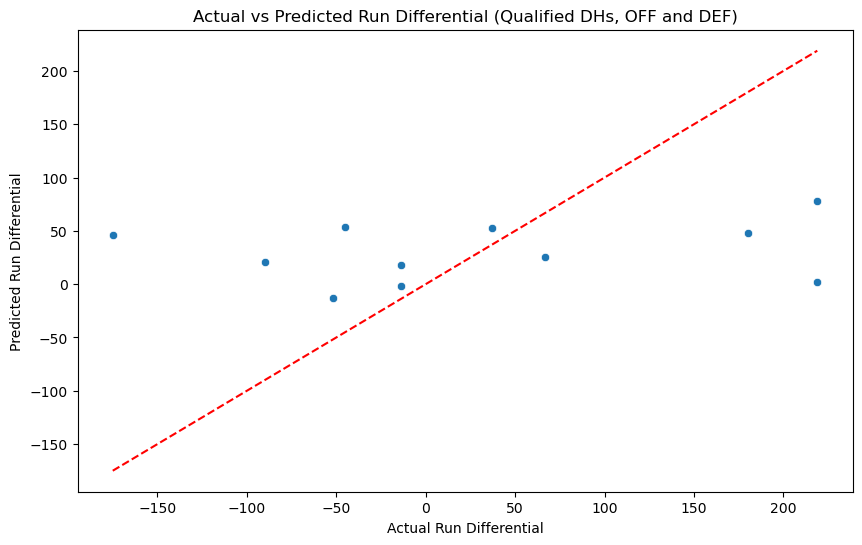

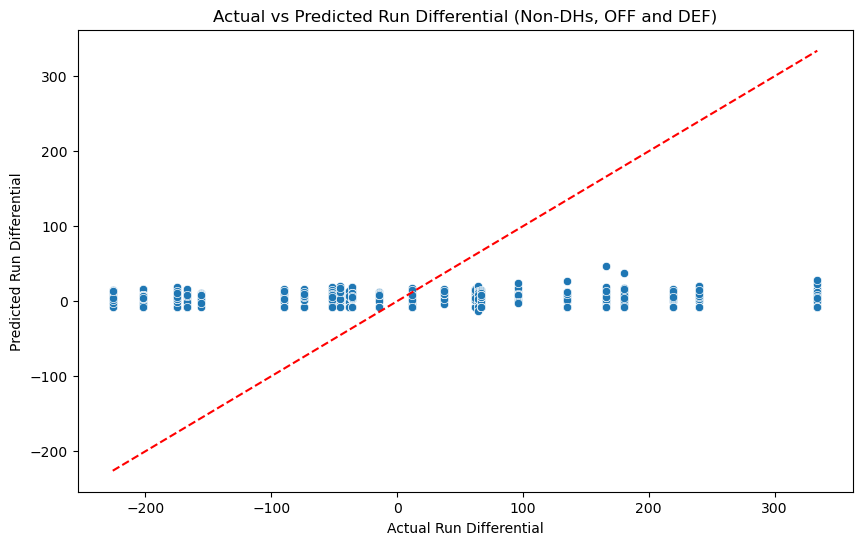

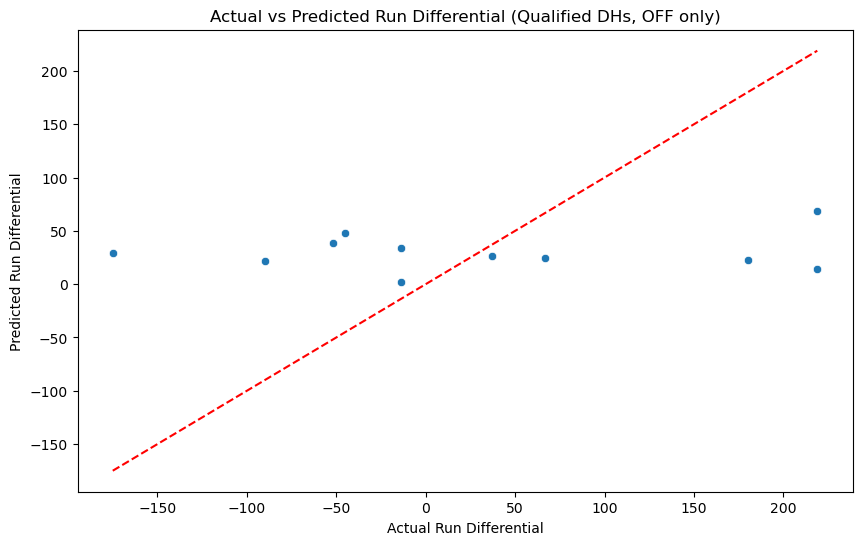

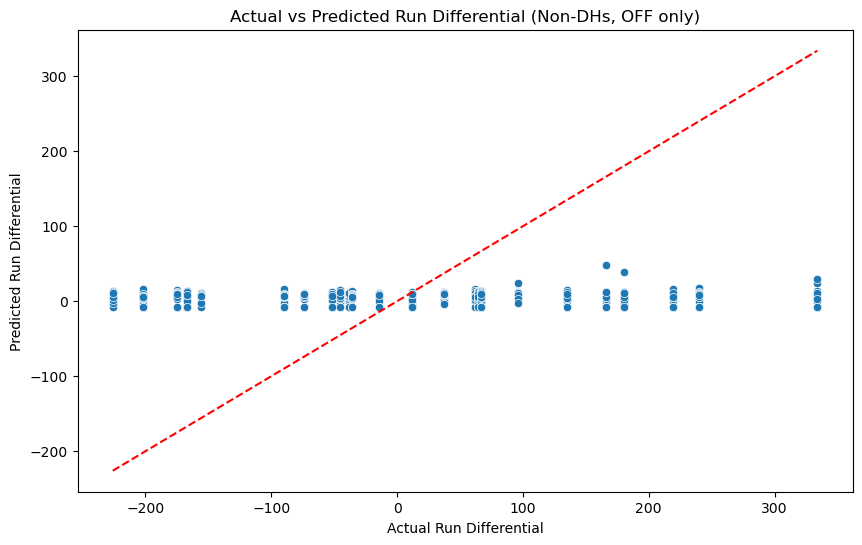

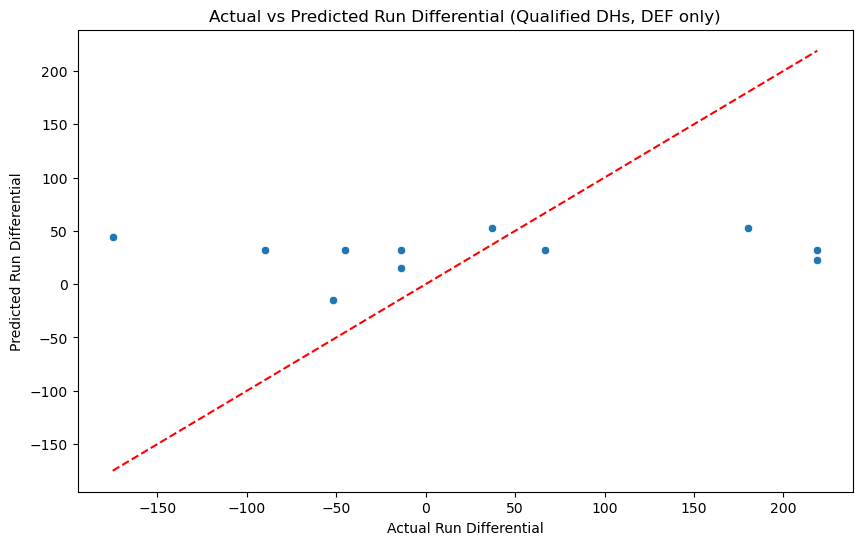

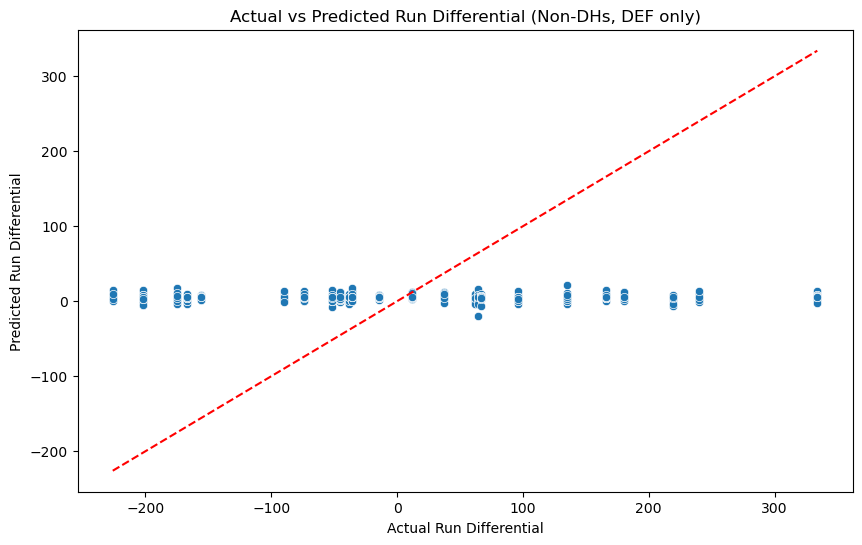

In [4]:
# Perform regression for qualified DHs
df_dh_combined, model_dh_combined = perform_regression(df_dh, ['OFF', 'DEF'], "Qualified DHs (OFF and DEF)")
df_non_dh_combined, model_non_dh_combined = perform_regression(df_non_dh, ['OFF', 'DEF'], "Non-DHs (OFF and DEF)")

# Perform regression for qualified DHs (OFF only)
df_dh_off, model_dh_off = perform_regression(df_dh, ['OFF'], "Qualified DHs (OFF only)")
df_non_dh_off, model_non_dh_off = perform_regression(df_non_dh, ['OFF'], "Non-DHs (OFF only)")

# Perform regression for qualified DHs (DEF only)
df_dh_def, model_dh_def = perform_regression(df_dh, ['DEF'], "Qualified DHs (DEF only)")
df_non_dh_def, model_non_dh_def = perform_regression(df_non_dh, ['DEF'], "Non-DHs (DEF only)")

# Function to plot actual vs predicted run differentials
def plot_results(data, predicted_col, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Run Differential', y=predicted_col, data=data)
    plt.plot([data['Run Differential'].min(), data['Run Differential'].max()], [data['Run Differential'].min(), data['Run Differential'].max()], color='red', linestyle='--')
    plt.xlabel('Actual Run Differential')
    plt.ylabel('Predicted Run Differential')
    plt.title(title)
    plt.show()

# Plotting the results for combined (OFF and DEF)
plot_results(df_dh_combined, 'Predicted_RunDiff_Qualified DHs (OFF and DEF)', 'Actual vs Predicted Run Differential (Qualified DHs, OFF and DEF)')
plot_results(df_non_dh_combined, 'Predicted_RunDiff_Non-DHs (OFF and DEF)', 'Actual vs Predicted Run Differential (Non-DHs, OFF and DEF)')

# Plotting the results for OFF only
plot_results(df_dh_off, 'Predicted_RunDiff_Qualified DHs (OFF only)', 'Actual vs Predicted Run Differential (Qualified DHs, OFF only)')
plot_results(df_non_dh_off, 'Predicted_RunDiff_Non-DHs (OFF only)', 'Actual vs Predicted Run Differential (Non-DHs, OFF only)')

# Plotting the results for DEF only
plot_results(df_dh_def, 'Predicted_RunDiff_Qualified DHs (DEF only)', 'Actual vs Predicted Run Differential (Qualified DHs, DEF only)')
plot_results(df_non_dh_def, 'Predicted_RunDiff_Non-DHs (DEF only)', 'Actual vs Predicted Run Differential (Non-DHs, DEF only)')
